In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.kernel_regression import KernelReg

In [104]:
class gamma:
    # class for parametric curve
    def __init__(self, f):
        self.f = f # f: [0, 1] -> R^d

    def plot(self, N=1000, **kwargs):
        t = np.linspace(0, 1, N)
        pts = np.array([self.f(ti) for ti in t])
        # plot dotted curve
        plt.plot(pts[:, 0], pts[:, 1], linestyle='dotted', **kwargs)

    def project(self, p, N=1000):
        # project point p onto curve, return closest point on curve and parameter value
        t = np.linspace(0, 1, N)
        pts = np.array([self.f(ti) for ti in t])
        dists = np.linalg.norm(pts - p, axis=1)
        idx = np.argmin(dists)
        return pts[idx], t[idx]


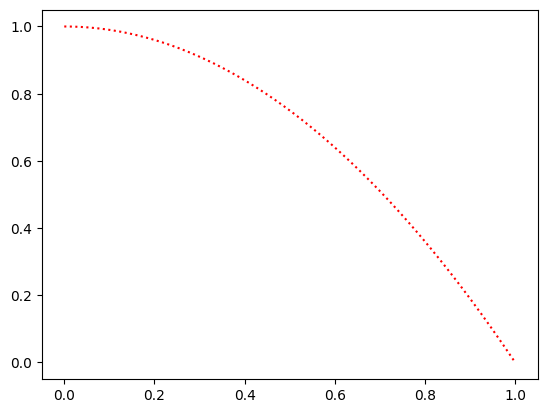

In [105]:
def quadratic(t):
    # example curve: quadratic
    return np.array([t, 1 - t**2])

curve = gamma(quadratic)

curve.plot(color='red')

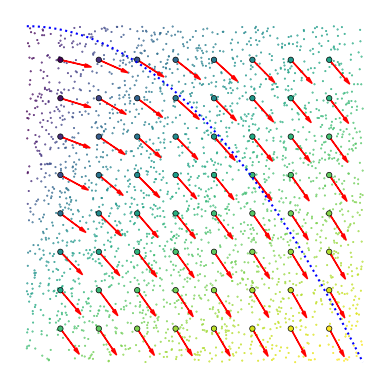

In [ ]:
# gaussian pdf
def gaussian_pdf(x, mu, sigma = np.eye(2) * 0.01):
    d = x.shape[0]
    coeff = 1 / ((2 * np.pi) ** (d / 2) * np.linalg.det(sigma) ** 0.5)
    exponent = -0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu)
    return coeff * np.exp(exponent)

# create density ratio
def density_ratio(x, x_0, kde, sigma = np.eye(2) * 0.01):
    p_x = kde(x)
    p_gx = gaussian_pdf(x, mu=x_0, sigma=sigma)
    return p_gx / p_x

# sample uniformly from [0, 1] x [0, 1]
N = 2500
x = np.random.rand(N)
y = np.random.rand(N)
X = np.vstack((x, y)).T
# generate Y by projecting X onto curve
Y = np.array([curve.project(Xi)[1] for Xi in X])

# sample 25 evenly spaced points in [0.1, 0.9]^2 to be test points
x_0s = np.array([[i, j] for i in np.linspace(0.1, 0.9, 8) for j in np.linspace(0.1, 0.9, 8)])
# x_0s = np.array([[0.8, 0.3]]) # test point


def LLSIR(X, Y, x_0, epsilon=0.2):
    # x_0: (n_test, d)
    kde = gaussian_kde(X.T)
    vel_estimates = []
    reg_estimates = []
    for x_0i in x_0:
        # get \epsilon neighborhood
        neighborhood_idx = np.linalg.norm(X - x_0i, axis=1) < epsilon
        X_neighborhood = X[neighborhood_idx]
        Y_neighborhood = Y[neighborhood_idx]

        # get density ratio at all points with gaussian centered at x_0i
        ratios = np.array([density_ratio(Xi, x_0i, kde) for Xi in X_neighborhood])
        # do density weighted linear regression to estimate tangent
        # fit linear regression to neighborhood points weighted by density ratio
        reg = LinearRegression()
        # ratios are [n, 1], need to flatten to [n,]
        reg.fit(X_neighborhood, Y_neighborhood, sample_weight=ratios.flatten())
        # get beta vector
        beta = reg.coef_
        # scale beta to unit length
        beta = beta / np.linalg.norm(beta)
        vel_estimates.append(beta)
        # center neighborhood points
        X_centered = X_neighborhood - x_0i
        # project centered points onto beta
        projections = X_centered @ beta
        # nonparametric regression of projections to Y_neighborhood
        nonparam_reg = KernelReg(endog=Y_neighborhood, exog=projections, var_type='c')
        # get fitted values
        yhat0 = nonparam_reg.fit(np.array([0.0]))[0][0]
        reg_estimates.append(yhat0)
    return np.array(vel_estimates), np.array(reg_estimates)
# test LLSIR
betas, y_hats = LLSIR(X, Y, x_0s, epsilon=0.1)
# plot data with color by Y value
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=0.2)
# make aspect equal
plt.gca().set_aspect('equal')
curve.plot(color='blue')
plt.axis('off');
for i, x_0i in enumerate(x_0s):
    beta = betas[i]
    # draw beta vector at x_0i
    # plot as arrow
    plt.arrow(x_0i[0], x_0i[1], 0.075 * beta[0], 0.075 * beta[1], head_width=0.01, head_length=0.02, fc='red', ec='red')
plt.scatter(
    x_0s[:, 0], x_0s[:, 1],
    c=y_hats, cmap='viridis',
    s=15, edgecolors='black', linewidths=0.5
)
plt.axis('off');